# FashionMNIST VAE

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from matplotlib.pyplot import imshow
from torch.distributions import constraints
#from sklearn.manifold import TSNE
from helper_functions import *



### Define the simulation parameters

In [16]:
params = { 
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28, 
    'DIM_Z':20,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'CHANNELS': 1, 'WIDTH': 28, 'HEIGHT': 28, 'DIM_Z': 20, 'use_cuda': False}


### Get the data

torch.Size([256, 1, 28, 28])


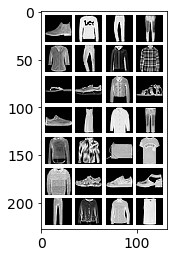

In [17]:
BATCH_SIZE = 256
kwargs = {'num_workers': 0, 'pin_memory': params["use_cuda"]}

trainset = torchvision.datasets.FashionMNIST('./FashionMNIST', train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.FashionMNIST('./FashionMNIST', train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:28],npadding=4)

### Instantiate VAE class 
This is the case without latent structure

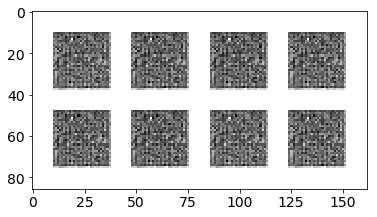

In [18]:
from encoder_decoder import *
from vae import *

#encoder = Encoder_MLP(params)
#decoder = Decoder_MLP(params)
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

vae.guide()
vae.model()
imgs_rec = vae.reconstruct(imgs)
show_batch(imgs_rec[:8])

In [19]:
### test_model(vae.model,vae.guide,Trace_ELBO())
### 
### #load_model(vae,"/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/","vae_v5_10")
### 
### import pyro.poutine as poutine
### #
### print("----MODEL---------")
### trace = poutine.trace(vae.model).get_trace()
### trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
### print(trace.format_shapes())
### #
### print("----GUIDE ---------")
### trace = poutine.trace(vae.guide).get_trace()
### trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
### print(trace.format_shapes())

In [20]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101
    
# setup the optimizer
adam_args = {"lr": 1.0e-3}
optimizer = Adamax(adam_args)

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))
train_loss, test_loss = [], []
min_loss = 999999

In [21]:
write_dir  = '/Users/ldalessi/VAE_PYRO/ARCHIVE/'

descriptor      = "MNIST_v3"
name_vae        = "vae_"+descriptor+"_"
name_train_loss = "train_loss_"+descriptor+"_"
name_test_loss  = "test_loss_"+descriptor+"_"
name_params     = "params_"+descriptor


save_obj(params,write_dir,name_params)

In [22]:
# training loop
for epoch in range(0,10*NUM_EPOCHS):
    vae.train()            
    
    loss = train(svi,trainloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
    train_loss.append(loss)   
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
    
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        loss = evaluate(svi,testloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
        test_loss.append(loss)
    
        if(test_loss[-1] < min_loss):
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
            min_loss = test_loss[-1]
            #### Save if you got a record 
            ###save_model(vae,write_dir,name_vae+str(epoch))       
            ###save_obj(test_loss,write_dir,name_test_loss+str(epoch))
            ###save_obj(train_loss,write_dir,name_train_loss+str(epoch))
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
            
    if(epoch % WRITE_FREQUENCY == 0):
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(test_loss,write_dir,name_test_loss+str(epoch))
        save_obj(train_loss,write_dir,name_train_loss+str(epoch))

loss=199679.78174
loss=198917.55811
loss=196676.03516
loss=196564.68359
loss=196159.90430
loss=196567.31592
loss=196024.95752
loss=195761.49414
loss=195523.90820
loss=195760.89941
loss=195690.36963
loss=195491.04102
loss=195214.11426
loss=194718.23877
loss=194408.23438
loss=194722.78516
loss=194613.45557
loss=194261.98975
loss=193856.26611
loss=194141.02930
loss=193926.76074
loss=193881.84814
loss=193985.82861
loss=193518.56689
loss=193353.63818
loss=193859.85547
loss=193329.95996
loss=193171.47412
loss=193346.85400
loss=193309.25488
loss=193013.20947
loss=192907.75391
loss=192938.97363
loss=193316.17334
loss=192604.72998
loss=192673.60352
loss=192929.29834
loss=192651.01758
loss=192592.69385
loss=192600.99561
loss=192011.47314
loss=192403.20068
loss=192125.93457
loss=191979.20410
loss=192103.49316
loss=192075.80469
loss=191851.94922
loss=191790.18701
loss=191753.52002
loss=191397.30127
loss=191165.27832
loss=191657.36377
loss=191314.86523
loss=191461.87891
loss=191456.30615
loss=19142

KeyboardInterrupt: 

# Check the results

In [ ]:
#write_dir = '/Users/ldalessi/VAE_PYRO/ARCHIVE/'

#descriptor      = "MNIST_v1"

#load_model(vae,write_dir,"vae_"+descriptor+"_400")
#test_loss = load_obj(write_dir,"test_loss_"+descriptor+"_400")
#train_loss = load_obj(write_dir,"train_loss_"+descriptor+"_400")
#name_vae = "vae_"+descriptor

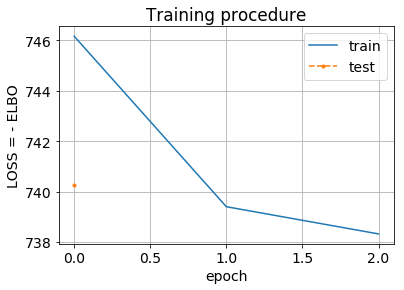

In [23]:
#plt.yscale('log')
y_shift=0
x_shift=0
plt.plot(np.arange(x_shift, x_shift+len(train_loss)), np.array(train_loss)+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(train_loss), TEST_FREQUENCY), np.array(test_loss)+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymax = 1.0)
#plt.xlim(xmin = 0, xmax=700)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()
#from matplotlib import pyplot as plt
#plt.savefig(write_dir+name_vae+'train.png')

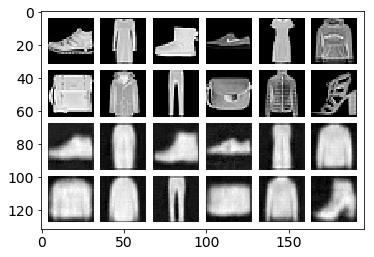

In [24]:
#imgs,labels = next(iter(testloader))
imgs,labels = next(iter(trainloader))
imgs_rec = vae.reconstruct(imgs)
show_2_batch(imgs[:12],imgs_rec[:12],npadding=4,nrow=6)

# compute the embedding

In [33]:
#imgs,labels = next(iter(testloader))
imgs,labels = next(iter(trainloader))
z = vae.encoder(imgs)

for data in testloader:
    if z_tot.shape[0] >= 30:
        break
    imgs,labels = data
    z = vae.encoder(imgs)
    z_tmp = z.z_mu.view(-1,params['DIM_Z']).detach().cpu().numpy()
    labels_tmp = labels.numpy()
    print(z_tmp.shape)
    
    try:
        z_tot = np.concatenate((z_tot, z_tmp),axis=0)
        labels_tot = np.concatenate((labels_tot, labels_tmp),axis=0)
    except:
        z_tot = z_tmp
        labels_tot = labels_tmp
        
z_tot[np.isnan(z_tot)] = 0
z_tot[z_tot > 1e100] = 1e100

In [39]:
print(z_tot.shape)
print(z_tot[:2])
print(labels_tot.shape)
print(labels_tot)

(257, 20)
[[ 1.00000000e-01  1.50000000e-01  2.00000000e-01  2.50000000e-01
   3.00000000e-01  4.00000000e-01  5.00000000e-01  6.00000000e-01
   8.00000000e-01  1.00000000e+00  1.50000000e+00  2.00000000e+00
   2.50000000e+00  3.00000000e+00  4.00000000e+00  5.00000000e+00
   6.00000000e+00  8.00000000e+00  1.00000000e+01  1.50000000e+01]
 [ 2.48505503e-01 -2.24386856e-01 -5.97901270e-02 -3.29002738e-02
  -1.88086420e-01  1.87692702e-01  4.74253535e-01  1.19653121e-01
  -4.36985493e-02  1.54043302e-01  5.86642623e-02  6.62499294e-02
  -9.25304890e-02  1.44816749e-02 -1.66813001e-01  3.45503725e-02
   6.09527156e-03 -1.65929151e+00 -3.39860588e-01 -1.19630337e-01]]
(257,)
[4. 9. 2. 1. 1. 6. 1. 4. 6. 5. 7. 4. 5. 7. 3. 4. 1. 2. 4. 8. 0. 2. 5. 7.
 9. 1. 4. 6. 0. 9. 3. 8. 8. 3. 3. 8. 0. 7. 5. 7. 9. 6. 1. 3. 7. 6. 7. 2.
 1. 2. 2. 4. 4. 5. 8. 2. 2. 8. 4. 8. 0. 7. 7. 8. 5. 1. 1. 2. 3. 9. 8. 7.
 0. 2. 6. 2. 3. 1. 2. 8. 4. 1. 8. 5. 9. 5. 0. 3. 2. 0. 6. 5. 3. 6. 7. 1.
 8. 0. 1. 4. 2. 3. 6. 7. 2. 

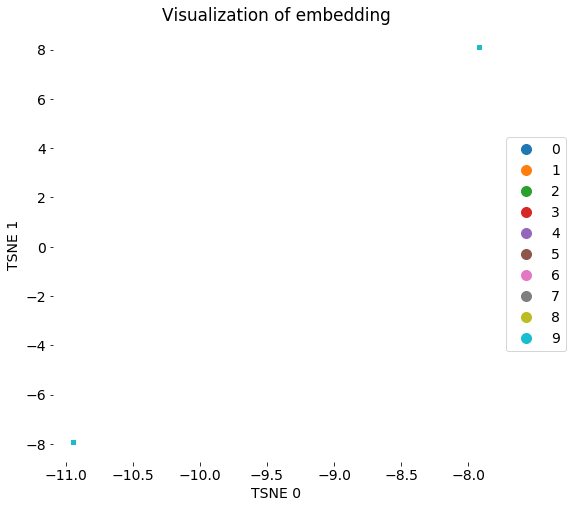

In [35]:
# and I know this sounds ridiculous but we have to do more
# dimensionality reduction to visualize our dimensionality reduction

from sklearn.manifold import TSNE

z_tsne = TSNE(n_components=2).fit_transform(z_tot)

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 8), frameon=False)
for k in np.unique(labels):
    plt.plot(z_tsne[labels==k, 0], 
             z_tsne[labels==k, 1], '.', ms=8, alpha=0.5)

lgnd = plt.legend(np.unique(labels).astype(int), 
                  loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(20)
    lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('TSNE 0')
plt.ylabel('TSNE 1')
plt.title('Visualization of embedding')
plt.box(on=None)
plt.show()